## Some information
- Maximum lenght of the brain signals : 919, 906, 594


- 768 - just maximum number of the data. (only 58 samples more than 786) ???


- Maximum number of chars: 66. Maximum number of tokens(inluded start and stop). 24

In [5]:
import numpy as np
from pathlib import Path
import scipy.io
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict
from torch.utils.data import Dataset

MAX_INPUT_LEN = 768 # 768
MAX_TOKENS = 25

DATE_TO_INDEX = {'t12.2022.04.28': 0,
                't12.2022.05.05': 1,
                't12.2022.05.17': 2,
                't12.2022.05.19': 3,
                't12.2022.05.24': 4,
                't12.2022.05.26': 5,
                't12.2022.06.02': 6,
                't12.2022.06.07': 7,
                't12.2022.06.14': 8,
                't12.2022.06.16': 9,
                't12.2022.06.21': 10,
                't12.2022.06.23': 11,
                't12.2022.06.28': 12,
                't12.2022.07.05': 13,
                't12.2022.07.14': 14,
                't12.2022.07.21': 15,
                't12.2022.07.27': 16,
                't12.2022.07.29': 17,
                't12.2022.08.02': 18,
                't12.2022.08.11': 19,
                't12.2022.08.13': 20,
                't12.2022.08.18': 21,
                't12.2022.08.23': 22,
                't12.2022.08.25': 23}




def block_specific_scaling(brain_list, idx_list):
    """
    Perform block-specific scaling on the input brain data.

    Args:
        brain_list (list): List of brain data arrays, each with shape [Time, 256].
        idx_list (list): List of block indices corresponding to each brain data array.

    Returns:
        list: List of scaled brain data arrays.

    # brain_list = [submit_dataset[i][0] for i in range(4)]
    # idx_list = [0, 0, 100, 100]
    # scaled_brain_list = block_specific_scaling(brain_list, idx_list)
    """

    
    # Group brain indices by block index
    block_idxs = defaultdict(list)
    for i, idx in enumerate(idx_list):
        block_idxs[idx].append(i)

    # Create a scaler for each block
    scalers = {}
    for block_idx, indices in block_idxs.items():
        all_brains_cat = np.concatenate([brain_list[i] for i in indices])
        scaler = MinMaxScaler().fit(all_brains_cat)
        scalers[block_idx] = scaler

    # Scale each brain data array using the corresponding block scaler
    scaled_brain_list = [scalers[idx].transform(brain) for brain, idx in zip(brain_list, idx_list)]
    return scaled_brain_list



def process_signal(brain_list, block_list):

    brain_list = block_specific_scaling(brain_list, block_list)
    return brain_list

def process_text(arr):
    return [str.strip() for str in arr]

def process_file(data_file):
    
    data = scipy.io.loadmat(data_file)
    date = data_file.stem
    n_trials = data['blockIdx'].shape[0]

    brain_list = [data['spikePow'][0][i] for i in range(n_trials)]
    block_list = [data['blockIdx'][i][0] for i in range(n_trials)]
    
    sentence_list = data['sentenceText']

    brain_list = process_signal(brain_list, block_list)
    sentence_list = process_text(sentence_list)

    date_list = [date] * n_trials
    return brain_list, sentence_list, date_list


def process_all_files(path):
    data = {'brain_list':[], 'sentence_list':[], 'date_list':[]}
    for data_file in sorted(path.glob('*.mat')):

        brains, sentences, dates = process_file(data_file)
        data['brain_list'].extend(brains)
        data['sentence_list'].extend(sentences)
        data['date_list'].extend(dates)

    return data

def find_long_samples(sample_list, max_length):
    """
    Find the indices of bad samples (length > max_length) in the list.
    Returns:
        list: List of indices corresponding to bad brain signals.
    """
    bad_indices = []
    for i, sample in enumerate(sample_list):
        if len(sample) > max_length:
            bad_indices.append(i)
    return bad_indices


def pad_truncate_brain_list(brain_list, max_length):
    """
    Pad or truncate each sample in the brain list to a specified maximum length.

    Args:
        brain_list (list): List of brain data arrays, each with shape [Time, 256].
        max_length (int): Maximum length to pad or truncate each sample.

    Returns:
        list: List of padded or truncated brain data arrays.
    """
    padded_brain_list = []
    for brain in brain_list:
        time_length = brain.shape[0]
        if time_length > max_length:
            # Truncate the sample if it exceeds the maximum length
            padded_brain = brain[:max_length, :]
        else:
            # Pad the sample with zeros if it is shorter than the maximum length
            pad_width = max_length - time_length
            padded_brain = np.pad(brain, ((0, pad_width), (0, 0)), mode='constant')
        
        padded_brain_list.append(padded_brain)
    
    return padded_brain_list

def get_tokenizer(tokenizer):
    bos = tokenizer.bos_token
    eos = tokenizer.eos_token

    def tokenize_txt(text):
        text = bos + text + eos 
        tokens = tokenizer(text).input_ids
        # labels = tokenizer(text, padding="max_length", max_length=64).input_ids
        # labels = [label if label != tokenizer.pad_token_id else -100 for label in labels]
        return tokens
    return tokenize_txt

def pad_token_list(token_list, max_tokens):
    num_padding = max_tokens - len(token_list)
    if num_padding > 0:
        token_list.extend([-100] * num_padding)
    return token_list

def remove_padding(token_list):
    return [token for token in token_list if token != -100]


class BrainDataset(Dataset):
    def __init__(self, path, tokenize_function=None): 

        print('Runed processing of the ', path)

        data = process_all_files(path)
            

        self.inputs = data['brain_list']
        self.targets = data['sentence_list']
        self.date = data['date_list']


        self.date_to_index = DATE_TO_INDEX
        

        bad_samples_idxs = find_long_samples(self.inputs, MAX_INPUT_LEN)
        self.inputs = pad_truncate_brain_list(self.inputs, MAX_INPUT_LEN)
        

        print('bad_samples', bad_samples_idxs)


        # process texts
        self.targets_tokens = []

        if tokenize_function is not None:
            for text in self.targets:
                tokens = tokenize_function(text)
                tokens_padded = pad_token_list(tokens, MAX_TOKENS)
                # tokens_padded = np.array(tokens_padded, type=np.int)
                self.targets_tokens.append(tokens_padded)
        else:
            self.targets_tokens = self.targets[:]
        
        self.remove_bad_samples(bad_samples_idxs)
        

    def __len__(self) -> int:
        return len(self.inputs)
    
    def remove_bad_samples(self, bad_indices):
        for i in reversed(bad_indices):
            del self.inputs[i]
            del self.targets[i]
            del self.targets_tokens[i]
            del self.date[i]

    def __getitem__(self, idx: int):
        
        input = self.inputs[idx]
        target = self.targets_tokens[idx]
        
        date = self.date[idx]
        date_idx = self.date_to_index[date]
                
        return input, target, date_idx

In [2]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('gpt2')
tokenize_function = get_tokenizer(tokenizer)

In [6]:
data_path = Path(r"D:\Work\brain-to-text-competition\data\competitionData")

submit_dataset = BrainDataset(data_path / 'test')

# submit_dataset = BrainDataset(data_path / 'competitionHoldOut')
len(submit_dataset)

Runed processing of the  D:\Work\brain-to-text-competition\data\competitionData\test
bad_samples [15, 17, 18, 22]


876

In [4]:
import torch 
loader = torch.utils.data.DataLoader(train_dataset, batch_size=8)

NameError: name 'train_dataset' is not defined

## Learn scalers.

In [ ]:
robust_scaler = RobustScaler(with_centering=False, with_scaling=True, 
                                                   quantile_range=(25.0, 75.0), copy=True, 
                                                   unit_variance=False)
min_max_scaler = MinMaxScaler()



brain_processed = robust_scaler.fit_transform(brain_cat.T).T

robust_scaler.fit(x.T)
min_max_scaler.fit(x.T)

x_new = robust_scaler.transform(x.T)
x_new = min_max_scaler.transform(x.T)


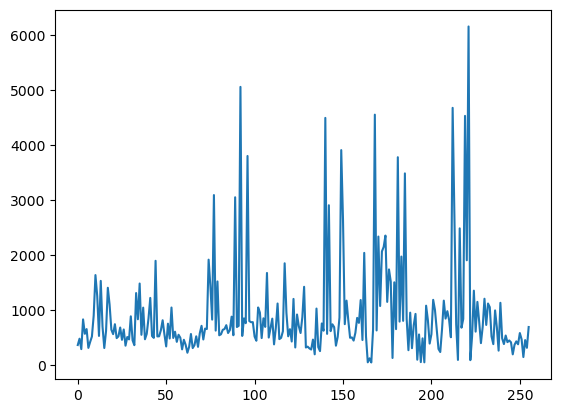

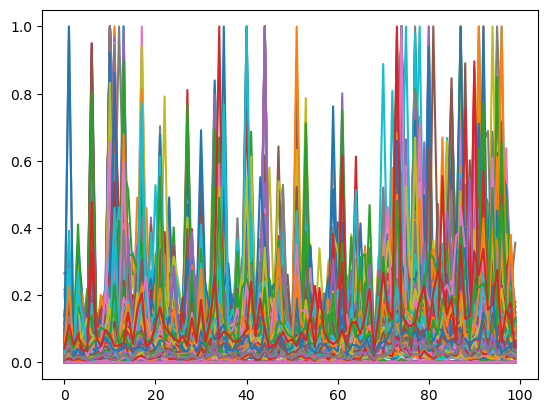

In [ ]:
plt.plot(x[0])

plt.show()

# plt.plot(x_new[:, 0])

plt.plot(x_new[:100, :])

-1.238822

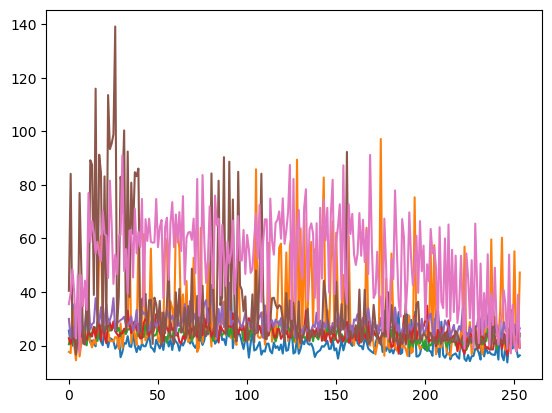

In [ ]:
plt.plot(x[:, 5:12] ** 0.5)

In [ ]:
def text_to_index(text_list):
    unique_texts = sorted(list(set(text_list)))
    text_to_index = {text: index for index, text in enumerate(unique_texts)}
    return text_to_index